In [2]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt

# Time series analysis
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Time series forecasting
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [3]:
target_state = "MA"
predict_file = {"expenditure":f"{target_state}_medicaid_expenditures.csv",
                "enrollment":f"{target_state}_medicaid_enrollment.csv"}
prediction = "enrollment"  
filename = predict_file[prediction]
target_data = predict_file[prediction]
final_df = pd.read_csv(filename)

## 1 Time Series Analysis

In [4]:
ts = final_df.set_index("ds")['y'].dropna()
ts.index = pd.to_datetime(ts.index)

### 2.1 Stationarity test

In [5]:
result = adfuller(ts)

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] < 0.05:
    print("Result: The time series is stationary (reject the null hypothesis)")
else:
    print("Result: The time series is non-stationary (fail to reject the null hypothesis)")

ADF Statistic: -2.0974132504158334
p-value: 0.2455560179186047
Critical Values: {'1%': -3.4672111510631, '5%': -2.877734766803841, '10%': -2.575403364197531}
Result: The time series is non-stationary (fail to reject the null hypothesis)


### 2.2 ACF & PACF plot

<Figure size 1200x500 with 0 Axes>

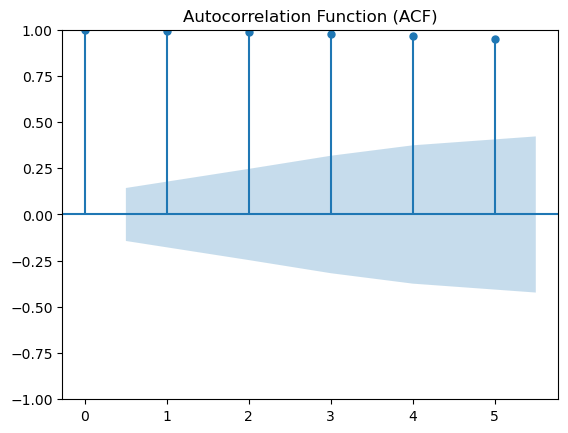

<Figure size 1200x500 with 0 Axes>

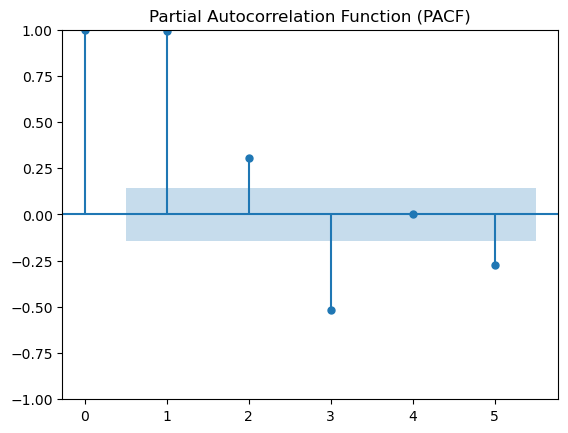

In [6]:
# ACF
plt.figure(figsize=(12,5))
plot_acf(ts, lags=5, alpha=0.05) 
plt.title('Autocorrelation Function (ACF)')
plt.show()

# PACF
plt.figure(figsize=(12,5))
plot_pacf(ts, lags=5, alpha=0.05, method='ywm')  
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

## 3 Forecasting

### 3.1 Prophet
Here we use R to construct Prophet to predict the expenditure in the next 10 years, we can see the process in prophet_expenditure.r or prophet_enrollment.r

### 3.2 ARIMA

In [7]:
# ARIMA model
model_arima = ARIMA(ts, order=(1,1,0))
model_arima_fit = model_arima.fit()

if prediction == "enrollment":
    forecast_steps = 10 * 12   # 10 years of monthly data
else:
    forecast_steps = 10         # 10 years of yearly data
forecast_arima = model_arima_fit.get_forecast(steps=forecast_steps)


if prediction == "enrollment":
    forecast_index = pd.date_range(start=ts.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')
else:
    # For yearly data, we assume the last date is the end of the last year
    # and we forecast from the start of the next year
    forecast_index = pd.date_range(start=ts.index[-1] + pd.DateOffset(years=1), periods=forecast_steps, freq='YS')

d:\Program Files\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Program Files\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Program Files\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Program Files\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


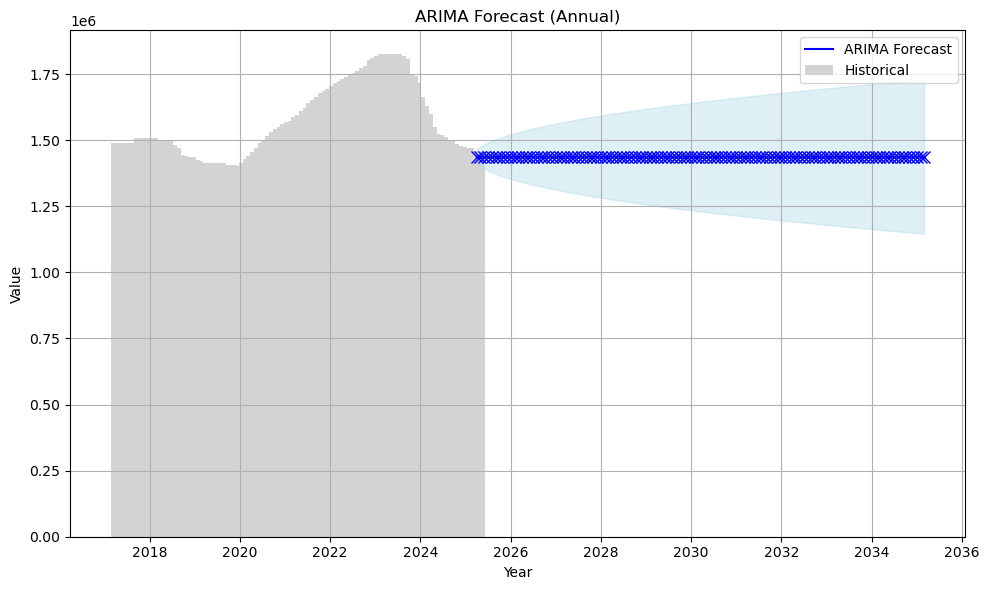

In [8]:
plt.figure(figsize=(10,6))

# historical data
plt.bar(ts.index, ts.values, label='Historical', color='lightgray', width=200) 

# ARIMA forecast
plt.plot(forecast_index, forecast_arima.predicted_mean.values, label='ARIMA Forecast', color='blue')
plt.plot(forecast_index, forecast_arima.predicted_mean.values, 'x', color='blue', markersize=8)

# confidence intervals
plt.fill_between(forecast_index,
                 forecast_arima.conf_int().iloc[:, 0],
                 forecast_arima.conf_int().iloc[:, 1], 
                 color='lightblue', alpha=0.4)

plt.legend()
plt.title("ARIMA Forecast (Annual)")
plt.xlabel("Year")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
df_forecast_arima = pd.DataFrame({
    'year': forecast_index.year,
    'forecast': forecast_arima.predicted_mean.values
})

df_forecast_arima.to_csv(f"results/{prediction}_forecast_ARIMA_{target_state}.csv", index=False)

### 3.3 GARCH

In [10]:
# GARCH model
model = arch_model(ts, vol='Garch', p=1, q=1, mean='AR', dist='normal')
res = model.fit(update_freq=5, disp='off')

print(res.summary())

# forecasting
if prediction == "enrollment":
    forecast_horizon = 10 * 12  # 10 years of monthly data
else:
    forecast_horizon = 10
forecast = res.forecast(horizon=forecast_horizon)

                           AR - GARCH Model Results                           
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2409.99
Distribution:                  Normal   AIC:                           4827.99
Method:            Maximum Likelihood   BIC:                           4840.91
                                        No. Observations:                  187
Date:                Sat, Jul 19 2025   Df Residuals:                      186
Time:                        02:53:22   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
Const      1.5468e+06  2.594e+04     59.635      0.000 [1.

d:\Program Files\Anaconda\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.735e+10. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.0001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [11]:
# conditional volatility forecast
cond_vol = np.sqrt(forecast.variance.values[-1, :])

print(f"conditional volatility forecast for the next {forecast_horizon} periods:")
for i, vol in enumerate(cond_vol, 1):
    print(f"conditional vol of term {i} = {vol:.6f}")

conditional volatility forecast for the next 120 periods:
conditional vol of term 1 = 107811.989813
conditional vol of term 2 = 107966.332884
conditional vol of term 3 = 108116.299852
conditional vol of term 4 = 108262.020887
conditional vol of term 5 = 108403.621935
conditional vol of term 6 = 108541.224871
conditional vol of term 7 = 108674.947653
conditional vol of term 8 = 108804.904467
conditional vol of term 9 = 108931.205861
conditional vol of term 10 = 109053.958882
conditional vol of term 11 = 109173.267199
conditional vol of term 12 = 109289.231222
conditional vol of term 13 = 109401.948223
conditional vol of term 14 = 109511.512443
conditional vol of term 15 = 109618.015196
conditional vol of term 16 = 109721.544976
conditional vol of term 17 = 109822.187551
conditional vol of term 18 = 109920.026056
conditional vol of term 19 = 110015.141086
conditional vol of term 20 = 110107.610778
conditional vol of term 21 = 110197.510899
conditional vol of term 22 = 110284.914921
condi

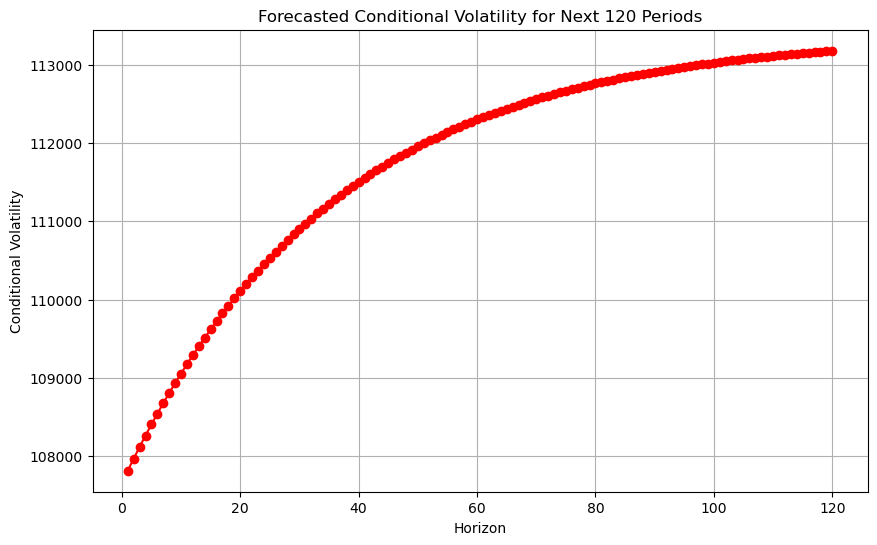

In [12]:
plt.figure(figsize=(10,6))
plt.plot(range(1, forecast_horizon + 1), cond_vol, marker='o', linestyle='-', color='red')
plt.title(f'Forecasted Conditional Volatility for Next {forecast_horizon} Periods')
plt.xlabel('Horizon')
plt.ylabel('Conditional Volatility')
plt.grid(True)
plt.show()

In [13]:
forecast_mean = forecast.mean.iloc[0].values 
forecast_var = forecast.variance.iloc[0].values  
forecast_vol = forecast_var**0.5  

if prediction == "enrollment":
    forecast_dates = pd.date_range(start=ts.index[-1] + pd.DateOffset(months=1), periods=forecast_horizon, freq='MS')
else:
    forecast_dates = pd.date_range(start=ts.index[-1] + pd.DateOffset(years=1), periods=forecast_horizon, freq='YS')

historical_df = pd.DataFrame({
    'date': ts.index,
    'value': ts.values,
    'type': 'historical'
})

forecast_df = pd.DataFrame({
    'date': forecast_dates,
    'mean': forecast_mean,
    'volatility': forecast_vol,
    'type': 'forecast'
})

historical_df = historical_df.rename(columns={'value': 'mean'})
historical_df['volatility'] = None  

result_df = pd.concat([historical_df, forecast_df], ignore_index=True)
print(result_df.head())

        date       mean        type  volatility
0 2017-06-01  1490673.0  historical         NaN
1 2017-06-01  1490673.0  historical         NaN
2 2017-07-01  1458560.0  historical         NaN
3 2017-07-01  1458560.0  historical         NaN
4 2017-08-01  1448697.0  historical         NaN


C:\Users\木木小呆猪\AppData\Local\Temp\ipykernel_24924\4215039098.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([historical_df, forecast_df], ignore_index=True)


### 3.4 LSTM

In [14]:
# data preparation
ts = ts.astype('float32')  
scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(ts.values.reshape(-1, 1))

In [15]:
# create sequences for LSTM
def create_sequences(data, look_back=12):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    return np.array(X), np.array(y)

look_back = 10  # use the previous 10 periods to predict the next one
X, y = create_sequences(ts_scaled, look_back)

# Reshape
X = X.reshape((X.shape[0], X.shape[1], 1))

# construct LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=100, verbose=0)

d:\Program Files\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
# forecast
forecast_steps = 120 if prediction == "enrollment" else 10
forecast_input = ts_scaled[-look_back:].reshape(1, look_back, 1)
forecast_scaled = []

for _ in range(forecast_steps):
    pred = model.predict(forecast_input, verbose=0)
    forecast_scaled.append(pred[0, 0])
    forecast_input = np.append(forecast_input[:, 1:, :], [[[pred[0, 0]]]], axis=1)

forecast = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).flatten()

# create forecast index
if prediction == "enrollment":
    forecast_index = pd.date_range(start=ts.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')
else:
    forecast_index = pd.date_range(start=ts.index[-1] + pd.DateOffset(years=1), periods=forecast_steps, freq='YS')

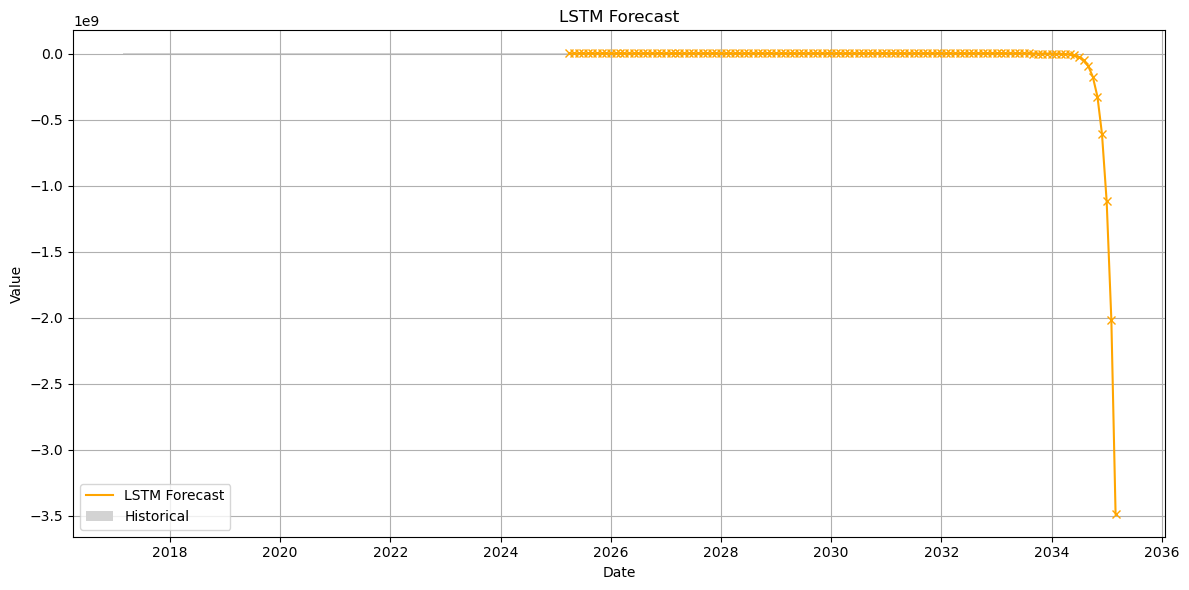

In [19]:
plt.figure(figsize=(12, 6))
plt.bar(ts.index, ts.values, label='Historical', color='lightgray', width=200)
plt.plot(forecast_index, forecast, label='LSTM Forecast', color='orange')
plt.plot(forecast_index, forecast, 'x', color='orange', markersize=6)

plt.legend()
plt.title("LSTM Forecast")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
forecast

array([ 1.4506826e+06,  1.4504278e+06,  1.4498806e+06,  1.4510764e+06,
        1.4524090e+06,  1.4554095e+06,  1.4567454e+06,  1.4595814e+06,
        1.4618040e+06,  1.4642332e+06,  1.4659206e+06,  1.4685781e+06,
        1.4711766e+06,  1.4736816e+06,  1.4761614e+06,  1.4786634e+06,
        1.4812691e+06,  1.4838888e+06,  1.4866048e+06,  1.4893795e+06,
        1.4922070e+06,  1.4950548e+06,  1.4979922e+06,  1.5010168e+06,
        1.5041216e+06,  1.5072662e+06,  1.5104488e+06,  1.5136716e+06,
        1.5169368e+06,  1.5202669e+06,  1.5236595e+06,  1.5271149e+06,
        1.5306364e+06,  1.5342340e+06,  1.5379095e+06,  1.5416772e+06,
        1.5455486e+06,  1.5495285e+06,  1.5536066e+06,  1.5578072e+06,
        1.5621448e+06,  1.5665695e+06,  1.5711254e+06,  1.5758252e+06,
        1.5806371e+06,  1.5855274e+06,  1.5905292e+06,  1.5956674e+06,
        1.6009372e+06,  1.6063511e+06,  1.6119281e+06,  1.6176826e+06,
        1.6236042e+06,  1.6295869e+06,  1.6357285e+06,  1.6420116e+06,
      